This Jupyter Notebook plots and analyzes ligand-detected 19F pseudo-2D ligand-detected longitudinal (spin-lattice, R1,eff) nuclear magnetic resonance spectroscopy (NMR) relaxation data of 5-fluoroindole in the absence and presence of varying concentrations of the non-structural protein 5A, domains 2 and 3 (NS5A-D2D3). Data should first be downloaded from Zenodo as detailed in ../README.md. Data are in .ft2 format. Filenames indicate protein concentration and replica index (e.g. '28_7uM_0.ft2' indicates 28.7uM NS5A-D2D3, first replicate). Output data are written to json files in ../json/ and are used for the tau_c_fit.

In [1]:
# import useful stuff
%matplotlib inline
import os, sys
import nmrglue as ng
import numpy as np
import glob
import json
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.pyplot import subplots
from scipy.optimize import curve_fit
from fit_raw import * # the included fit_raw.py file contains some useful functions

Optimization terminated successfully.
         Current function value: 6741129.716252
         Iterations: 3
         Function evaluations: 11
Optimization terminated successfully.
         Current function value: 8330163.089750
         Iterations: 3
         Function evaluations: 11
Optimization terminated successfully.
         Current function value: 8218163.577477
         Iterations: 3
         Function evaluations: 11
Optimization terminated successfully.
         Current function value: 7142607.500523
         Iterations: 3
         Function evaluations: 11
Optimization terminated successfully.
         Current function value: 7290479.889878
         Iterations: 3
         Function evaluations: 11
Optimization terminated successfully.
         Current function value: 8142727.858950
         Iterations: 3
         Function evaluations: 11
Optimization terminated successfully.
         Current function value: 8099140.839800
         Iterations: 3
         Function evaluations: 11

/Users/gabiheller/anaconda3/lib/python3.6/site-packages/nmrglue/process/proc_base.py:937: ComplexWarning: Casting complex values to real discards the imaginary part
  ).astype(data.dtype)


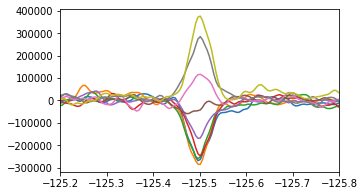

d_59_0uM_0


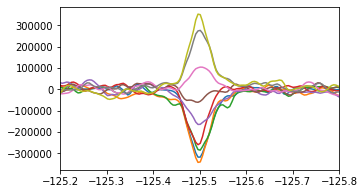

d_9_3uM_1


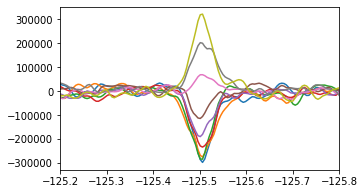

d_9_3uM_0


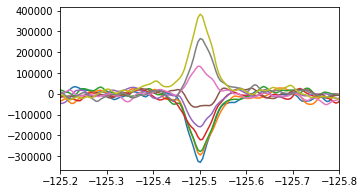

d_0_0uM_1


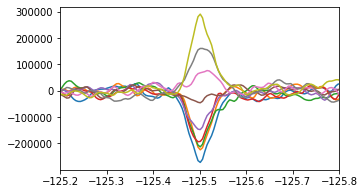

d_28_7uM_2


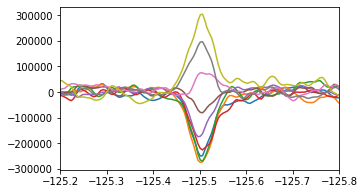

d_0_0uM_0


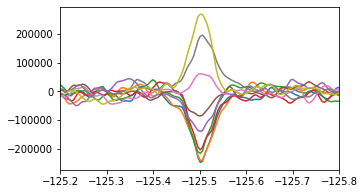

d_87_2uM_0


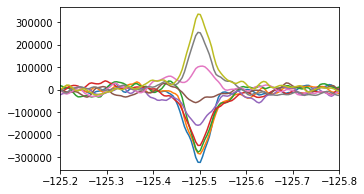

d_28_7uM_1


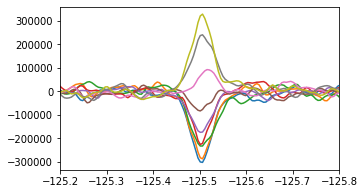

d_28_7uM_0


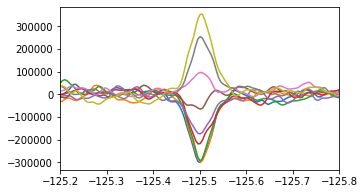

In [2]:
# Plot various 1D slices from each inversion recovery experiment

# Create an instance of the fit_raw class
fit_1D_19F = fit_raw()

# Read and process data
dic, data = fit_1D_19F.read_data('../Data/19F_R1eff_ft2_data/')

# Check raw data
for key in data.keys():
    print(key)
    fig, ax = plt.subplots(figsize=(5,3))
    # Get the x-axis values (ppm_real)
    udic = ng.pipe.guess_udic(dic[key], data[key])
    ppm_real = np.linspace(-125+-(udic[1]['sw']/udic[1]['obs'])/2, -125+(udic[1]['sw']/udic[1]['obs'])/2, num=data[key][0].shape[0])
    for i in range(0,data[key].shape[0]):
    # Plot the slices 
        ax.plot(ppm_real, data[key][i], label=key + " uM")
        ax.set_xlim(-125.2, -125.8)
    plt.show()


Now fitting d_59_0uM_1


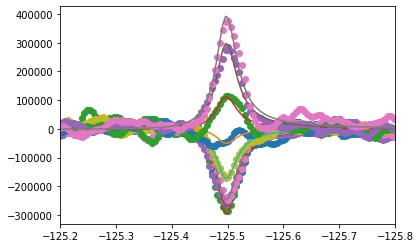

Now fitting d_59_0uM_0


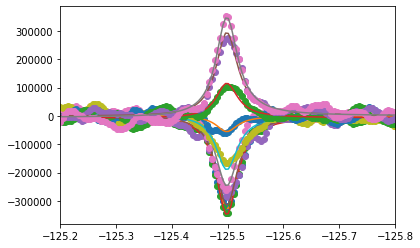

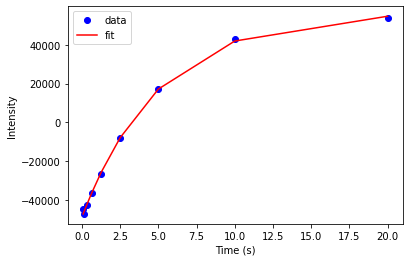

For 59.0 uM: R1: 0.19601940738835671 +/- 0.007945412883620872 seconds^-1
Now fitting d_9_3uM_1


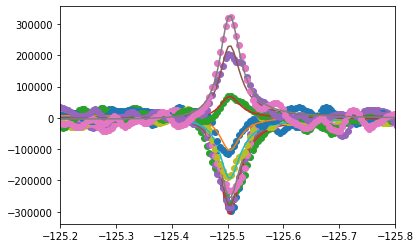

Now fitting d_9_3uM_0


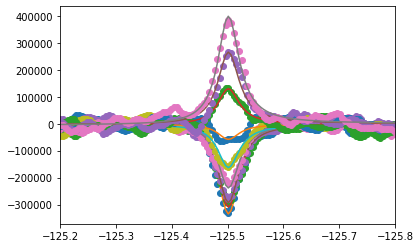

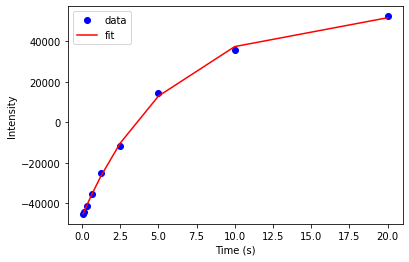

For 9.3 uM: R1: 0.1773836636385706 +/- 0.00798344125792127 seconds^-1
Now fitting d_0_0uM_1


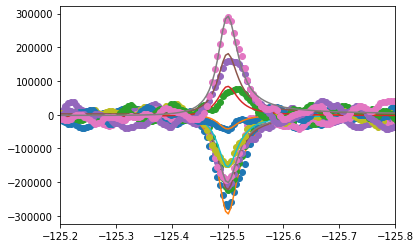

Now fitting d_0_0uM_0


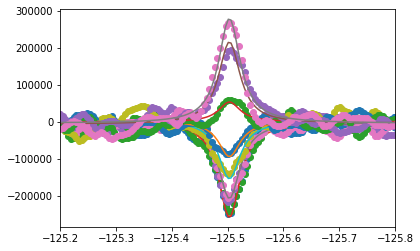

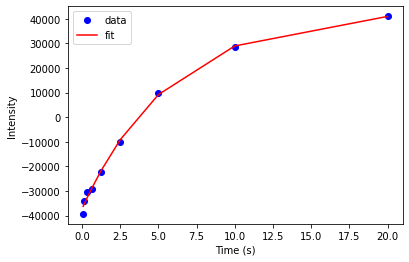

For 0.0 uM: R1: 0.17084364788497416 +/- 0.013227090455241317 seconds^-1
Now fitting d_28_7uM_2


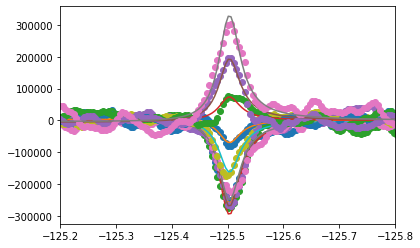

Now fitting d_28_7uM_1


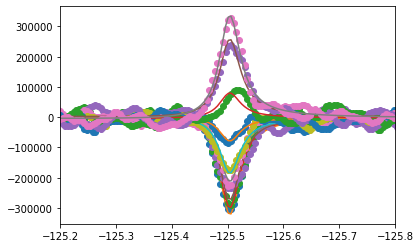

Now fitting d_28_7uM_0


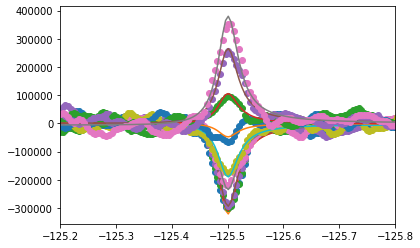

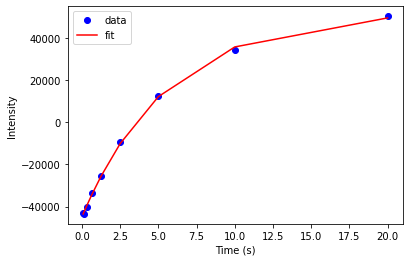

For 28.7 uM: R1: 0.1766481736897122 +/- 0.006826704608619719 seconds^-1
Now fitting d_87_2uM_0


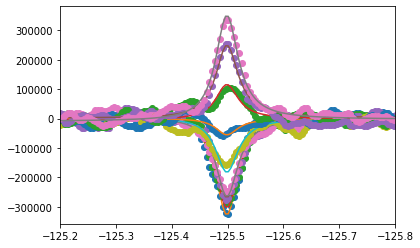

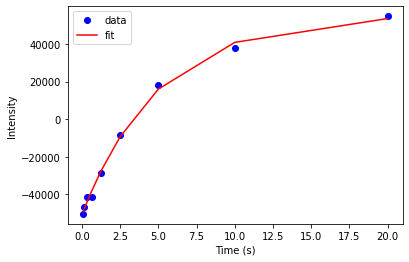

For 87.2 uM: R1: 0.1978682294711045 +/- 0.013875637306529097 seconds^-1


In [3]:
# Create a dictionary to group data by concentration
group_dict = {}
for key in data.keys():
    prefix = key.split('_')[1:3]
    prefix_dec = prefix[1].split('uM')
    join = prefix[0] + "." + "".join(prefix_dec)
    if join.startswith('d'):
        continue
    if join not in group_dict:
        group_dict[join] = []
    group_dict[join].append(key)

# Create a dictionary to store vals by concentration
concs_r1_av = {}
concs_r1_se = {}

# Loop over grouped data, calculate average and standard error, and plot
for key in group_dict:
    # Calculate average and standard error
    ints = []

    for i in group_dict[key]:
        print('Now fitting', i)
        # Fit each slice to get intensities
        intensities = fit_1D_19F.fit_IR_slices(dic=dic[i], data_list=data[i])
        
        ints.append(intensities)
    # Fit intensities to get R1
    popt, pcov, R1, R1err = fit_1D_19F.fit_IR_data(y=np.mean(np.asarray(ints), axis=0) )
    print('For', key,'uM:', 'R1:', R1, '+/-', R1err, 'seconds^-1')
    
    concs_r1_av[key] = R1
    concs_r1_se[key] = R1err


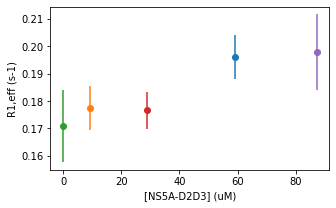

In [4]:
# Plot R1,eff values as a function of NS5A-D2D3 concentration
fig, ax = plt.subplots(figsize=(5,3))
for key in concs_r1_av:
    ax.scatter(np.float(key), (concs_r1_av[key]))
    ax.errorbar(np.float(key), (concs_r1_av[key]), yerr=concs_r1_se[key])
ax.set_xlabel('[NS5A-D2D3] (uM)')
ax.set_ylabel('R1,eff (s-1)')
ax.ticklabel_format(useOffset=False)
plt.show()

In [5]:
# Save the dictionaries to json files in ../json to be used in tau_c_fit
with open('../json/R1_av.json', 'w') as outfile:
    json.dump(concs_r1_av, outfile)
    
with open('../json/R1_se.json', 'w') as outfile:
    json.dump(concs_r1_se, outfile)